Original Class Distribution: Counter({1: 1655, 2: 295, 3: 176})
After SMOTE Class Distribution: Counter({2: 1655, 1: 1655, 3: 1655})

Decision Tree - Accuracy: 95.57%
              precision    recall  f1-score   support

           1       0.96      0.93      0.95       353
           2       0.92      0.95      0.94       317
           3       0.98      0.98      0.98       323

    accuracy                           0.96       993
   macro avg       0.96      0.96      0.96       993
weighted avg       0.96      0.96      0.96       993



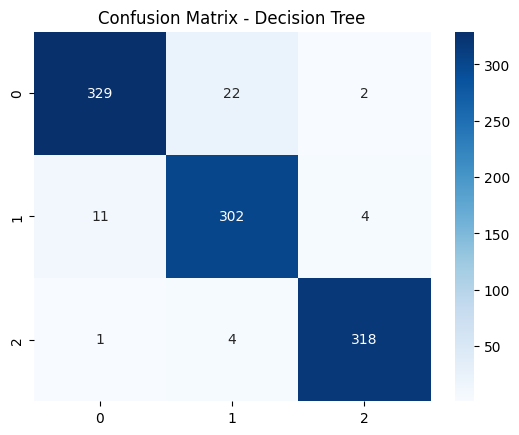


KNN - Accuracy: 93.66%
              precision    recall  f1-score   support

           1       0.98      0.86      0.92       353
           2       0.86      0.97      0.91       317
           3       0.98      0.99      0.98       323

    accuracy                           0.94       993
   macro avg       0.94      0.94      0.94       993
weighted avg       0.94      0.94      0.94       993



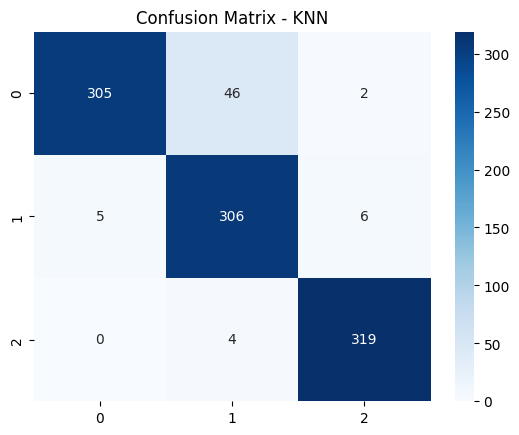


Random Forest - Accuracy: 91.34%
              precision    recall  f1-score   support

           1       0.94      0.88      0.90       353
           2       0.86      0.91      0.88       317
           3       0.95      0.96      0.95       323

    accuracy                           0.91       993
   macro avg       0.91      0.91      0.91       993
weighted avg       0.91      0.91      0.91       993



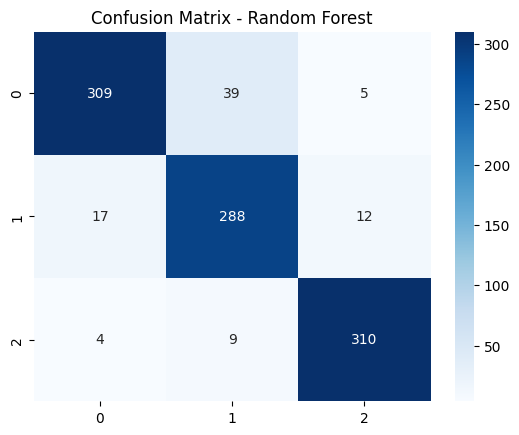

KeyboardInterrupt: 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("fetal_health.csv")

# Define features and target
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().astype(int)

# Display original class distribution
print("Original Class Distribution:", Counter(y))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert y_resampled to integer type (SMOTE might introduce float labels)
y_resampled = y_resampled.astype(int)

# Display new class distribution
print("After SMOTE Class Distribution:", Counter(y_resampled))


# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# --------------------------------------
# ✅ 1. Manual Decision Tree
# --------------------------------------
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class ManualDecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        if depth >= self.max_depth or len(unique_classes) == 1 or num_samples < self.min_samples_split:
            return Node(value=Counter(y).most_common(1)[0][0])

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return Node(value=Counter(y).most_common(1)[0][0])

        left_idx = X[:, best_feature] <= best_threshold
        right_idx = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = X[:, feature] > threshold
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gain = self._information_gain(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _entropy(self, y):  # ✅ Add 'self' as the first argument
       values, counts = np.unique(y, return_counts=True)  # Works with floats too
       probabilities = counts / len(y)
       return -np.sum(probabilities * np.log2(probabilities + 1e-9))


    def _information_gain(self, y, y_left, y_right):
        return self._entropy(y) - (len(y_left) / len(y) * self._entropy(y_left) + len(y_right) / len(y) * self._entropy(y_right))

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _predict(self, x, node):
        if node.value is not None:
            return node.value
        return self._predict(x, node.left if x[node.feature] <= node.threshold else node.right)

# --------------------------------------
# ✅ 2. Manual K-Nearest Neighbors (KNN)
# --------------------------------------
class ManualKNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_neighbors = np.argsort(distances)[:self.k]
            labels = [self.y_train[i] for i in k_neighbors]
            predictions.append(Counter(labels).most_common(1)[0][0])
        return np.array(predictions)

# --------------------------------------
# ✅ 3. Manual Random Forest
# --------------------------------------
class ManualRandomForest:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2):
        self.n_trees = n_trees
        self.trees = [ManualDecisionTree(max_depth, min_samples_split) for _ in range(n_trees)]

    def fit(self, X, y):
        for tree in self.trees:
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree.fit(X[idxs], y[idxs])

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

# --------------------------------------
# ✅ 4. Manual Gradient Boosting
# --------------------------------------
class ManualGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X, y):
        residuals = y.astype(np.float64)
        for _ in range(self.n_estimators):
            tree = ManualDecisionTree(max_depth=7)
            tree.fit(X, residuals)
            self.models.append(tree)
            residuals -= self.learning_rate * tree.predict(X)
    def predict(self, X):
        preds = np.sum([self.learning_rate * tree.predict(X) for tree in self.models], axis=0)
        return np.round(preds).astype(int)

class ManualXGBoost:
    def __init__(self, n_estimators=200, learning_rate=0.05, max_depth=5):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        predictions = np.zeros(len(y))
        for _ in range(self.n_estimators):
            residuals = y - predictions  # Compute residuals (negative gradient)
            tree = ManualDecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.models.append(tree)
            predictions += self.learning_rate * tree.predict(X)  # Update predictions

    def predict(self, X):
        preds = np.sum([self.learning_rate * tree.predict(X) for tree in self.models], axis=0)
        return np.round(preds).astype(int)


# ✅ Train & Evaluate Models
models = {
    "Decision Tree": ManualDecisionTree(),
    "KNN": ManualKNN(k=5),
    "Random Forest": ManualRandomForest(),
    "Gradient Boosting": ManualGradientBoosting(),
    "XGBoost": ManualXGBoost()
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n{name} - Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
